In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import resample
import random
import import_ipynb
import Prosjekt1 


### Looking at terrain and selecting a section

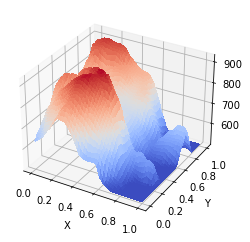

In [99]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
terrain2 = imread('SRTM_data_Norway_2.tif')
# Show the terrain
N = 100
end = -100
start = end - N
poly = 5
terrain = terrain1[start:end, :N]

x = np.linspace(0,1, terrain.shape[0])
y = np.linspace(0,1, terrain.shape[0])
x_mesh, y_mesh = np.meshgrid(x,y)
z = terrain
#print(len(z))
#print(len(x))
#print(len(x_mesh))

x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
z_flat = np.ravel(z)

#print(len(x_flat))
#print(len(y_flat))
#print(len(z_flat))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(x_mesh, y_mesh, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()


#### Using a 20 degree polynomial linear OLS to consider scaling

In [100]:
degree = 20

X = create_X(x, y, degree)
#Splits 1/3 for testing and 4/5 for training
for i, func in enumerate(func_list):

    #Splits 1/4 for testing and 3/4 for training
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=1/4)
    X_train_scaled, X_test_scaled, z_train_scaled, z_test_scaled = func(X_train, X_test, z_train, z_test)
    try:
        beta = find_beta(X_train_scaled, z_train_scaled)
        z_ = X_test_scaled @ beta
        
        #Find estimated of quality of fmodel fit 
        scores_OLS_scaled[i, 0] = MSE(z_test_scaled, z_)
        scores_OLS_scaled[i, 1] = R2(z_test_scaled, z_)
    except ValueError:
        scores_OLS_scaled[i, 0] = MSE(np.nan, np.nan)
        scores_OLS_scaled[i, 1] = R2(np.nan, np.nan)
        print(len(z), len(X))
        print(len(X_train_scaled), len(z_train_scaled))

scaled_df1 = pd.DataFrame(scores_OLS_scaled, columns = ('MSE test', 'R2 test')) 
d = pd.concat([scaled_df1], axis =1)
names = ['Standard', 'Mean', 'MinMax', 'Robustscaler', 'None']
d['scaler'] = names
d[['scaler', 'MSE test','R2 test']].set_index('scaler')


100 100
75 7500
100 100
75 7500


,MSE test,R2 test
scaler,,
Standard,0.842831,0.231476
Mean,14785.911444,0.052512
MinMax,NaN,NaN
Robustscaler,NaN,NaN
None,167.216761,0.990518


Problems with scaling, chosing not to scale the data or the standard scaler

#### Trying a simple linear OLS of 5 to 20 degree polynomial

In [101]:
degrees = np.arange(5, 21, 1)

scores_OLS_basic = np.zeros((len(degrees), 2))
scores_OLS_basic_train = np.zeros((len(degrees), 2))

for d, degree in enumerate(degrees):

    X = create_X(x, y, degree)

    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=1/4)
    X_train, X_test, z_train, z_test = standardscaler(X_train, X_test, z_train, z_test)

    beta = find_beta(X_train, z_train)

    z_ = X_test @ beta
    trained_z = X_train @ beta
    
    #Find estimated of quality of fmodel fit 
    scores_OLS_basic[d-1, 0] = MSE(z_test, z_)
    scores_OLS_basic[d-1, 1] = R2(z_test, z_)
    scores_OLS_basic_train[d-1, 0] = MSE(z_train, trained_z)
    scores_OLS_basic_train[d-1, 1] = R2(z_train, trained_z)
    

In [102]:
test_df = pd.DataFrame(scores_OLS_basic, columns=['MSE_test', 'R2_test'])
train_df = pd.DataFrame(scores_OLS_basic_train, columns=['MSE_train', 'R2_train'])
OLS_df = pd.concat([test_df,train_df],axis=1)
display(OLS_df)

,MSE_test,R2_test,MSE_train,R2_train
0,0.837923,0.216164,0.852873,0.147127
1,0.854734,0.012154,0.873578,0.126422
2,0.862234,-0.038146,0.862035,0.137965
3,0.876211,0.188196,0.845638,0.154362
4,0.861756,0.117266,0.856539,0.143461
5,0.847284,0.129753,0.850158,0.149842
6,0.859289,0.155073,0.841245,0.158755
7,0.823932,0.214642,0.844141,0.155859
8,0.848967,0.094392,0.857250,0.142750
9,0.846598,0.119648,0.846563,0.153437


NOT QUITE RIGHT

#### Trying to bootstrap

In [103]:
scores_OLS_boot = np.zeros((len(degrees), 2))
metrics = {'degree': degrees,'error': [], 'bias': [], 'variance': []}

for degree in degrees:
    X = create_X(x, y, degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=1/4)
    
    boot_n = 50

    bt_MSE, bt_R2, error, bias, var = bootstrap(X_train,z_train,X_test, z_test, iterations = boot_n) #bootstrapping the z-values to get a resampled set of the 'observed' data
    metrics['error'].append(error)
    metrics['bias'].append(bias)
    metrics['variance'].append(var)
    

    scores_OLS_boot[degree-1, 0] = bt_MSE
    scores_OLS_boot[degree-1, 1] = bt_R2

    
estimates = pd.DataFrame(scores_OLS_boot, columns=['bt_MSE', 'bt_R2'])
bt_results = pd.concat([pd.DataFrame(metrics), estimates], axis = 1)
bt_results = bt_results.set_index('degree')
display(bt_results)

ValueError: could not broadcast input array from shape (2500,) into shape (25,)

Something wrong here too

In [96]:
kfolds = 5
scores_OLS_CV = np.zeros((maxdegree, 1))
MSE_degrees = []
for degree in degrees:

    
    X = create_X(x, y, degree)

    scores,MSE_cv = cross_validation(X, z, kfolds)

    scores_OLS_CV[degree-1, 0] = MSE_cv 

 
datf = pd.DataFrame({'MSE_cv': scores_OLS_CV[:,0], 'degree': degrees}).set_index('degree')
display(pd.concat([datf, bt_results], axis=1))


TypeError: cross_validation() missing 2 required positional arguments: 'lmbda' and 'find_beta'

#### Trying rigde and lasso